# DeepGraphCNN

### Text-to-graph

In [20]:
import re
import networkx as nx
from nltk.corpus import stopwords
import nltk
import pymorphy2

In [7]:
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\desswell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def preprocess_text(text):
    """
    Функция предобработки текста
    Алгоритм:
      1. Приведение к нижнему регистру.
      2. Токенизация (выделение слов, содержащих русские буквы).
      3. Удаление стоп-слов.
      4. Нормализация (лемматизация) слов с использованием pymorphy2.
      
    :param text: Исходный текст
    
    :return normalized_tokens: Предобработанный текст
    """
    text = text.lower()  
    tokens = re.findall(r'\b[а-яё]+\b', text)
    
    russian_stopwords = set(stopwords.words("russian"))
    filtered_tokens = [token for token in tokens if token not in russian_stopwords]
    
    morph = pymorphy2.MorphAnalyzer()
    normalized_tokens = [morph.parse(token)[0].normal_form for token in filtered_tokens]
    
    return normalized_tokens

In [15]:
def build_graph_of_words(tokens, window_size=4):
    """
    Функция построения графа слов (Graph-of-Words) из списка токенов.
    Алгоритм:
      - Каждый токен становится узлом графа.
      - Для каждого слова создаются ребра с последующими словами, попадающими в окно.
      - Вес ребра (weight) увеличивается при повторном совместном появлении.
      
    :param tokens: Список токенов (слов) после предобработки.
    :param window_size: Размер скользящего окна для определения соседства слов.
    
    :return G: Граф (объект networkx.Graph), в котором узлы – слова, а ребра имеют атрибут веса, отражающий число совместных появлений.
    """
    G = nx.Graph()
    n = len(tokens)
    
    for i in range(n):
        word_i = tokens[i]
        if not G.has_node(word_i):
            G.add_node(word_i)
        
        window_end = min(i + window_size, n)
        for j in range(i + 1, window_end):
            word_j = tokens[j]
            if word_i == word_j:
                continue
            if G.has_edge(word_i, word_j):
                G[word_i][word_j]['weight'] += 1
            else:
                G.add_edge(word_i, word_j, weight=1)
    return G

In [16]:
text = ("Это пример текста на русском языке. Мы пытаемся построить граф слов, "
        "где слова соединяются, если они встречаются вместе в окне заданного размера.")

tokens = preprocess_text(text)
print("Токены:", tokens)

graph = build_graph_of_words(tokens, window_size=3)


print("\nУзлы графа:")
print(list(graph.nodes()))

print("\nРебра графа с весами:")
for u, v, data in graph.edges(data=True):
    print(f"{u} -- {v}, weight: {data['weight']}")


Токены: ['это', 'пример', 'текст', 'русский', 'язык', 'пытаться', 'построить', 'граф', 'слово', 'слово', 'соединяться', 'встречаться', 'вместе', 'окно', 'задать', 'размер']

Узлы графа:
['это', 'пример', 'текст', 'русский', 'язык', 'пытаться', 'построить', 'граф', 'слово', 'соединяться', 'встречаться', 'вместе', 'окно', 'задать', 'размер']

Ребра графа с весами:
это -- пример, weight: 1
это -- текст, weight: 1
пример -- текст, weight: 1
пример -- русский, weight: 1
текст -- русский, weight: 1
текст -- язык, weight: 1
русский -- язык, weight: 1
русский -- пытаться, weight: 1
язык -- пытаться, weight: 1
язык -- построить, weight: 1
пытаться -- построить, weight: 1
пытаться -- граф, weight: 1
построить -- граф, weight: 1
построить -- слово, weight: 1
граф -- слово, weight: 2
слово -- соединяться, weight: 2
слово -- встречаться, weight: 1
соединяться -- встречаться, weight: 1
соединяться -- вместе, weight: 1
встречаться -- вместе, weight: 1
встречаться -- окно, weight: 1
вместе -- окно, we

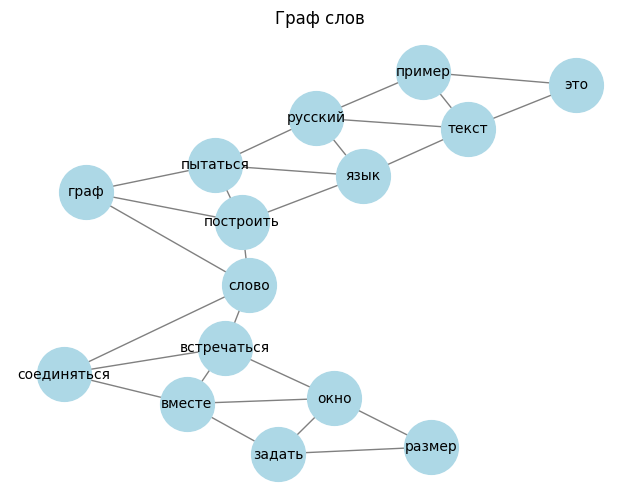

In [34]:
import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(graph)
plt.figure(figsize=(8, 6))
nx.draw_networkx(graph, pos, with_labels=True, node_color="lightblue",
                 edge_color="gray", node_size=1500, font_size=10, arrows=True)
plt.title("Граф слов")
plt.axis('off')
plt.show()

### Generate sub-graphs


In [23]:
from collections import deque
import numpy as np

In [29]:
def extract_subgraph_nodes(G, center, d):
    """
    Функция, которая извлекает подграф для центрального узла center с нормализацией:
      - Выполняется обход в ширину (BFS) с сохранением уровня (глубины) каждого узла.
      - Узлы группируются по уровням; в каждом уровне узлы сортируются по степени.
      - Если степень равна, можно добавить дополнительное упорядочивание (например, лексикографически).
      - Формируется итоговый упорядоченный список узлов, который усекается до размера d, а при недостатке узлов дополняется фиктивными значениями "DUMMY".
    
    :param G: Граф
    :param center: Узел от которого строится саб-граф
    :param d: d = len(sub_nodes), длина саб-графа
    
    :return ordered_nodes: список узлов для саб-графа
    """
    visited = {}
    levels = {}
    queue = deque([(center, 0)])
    visited[center] = 0

    # BFS с отслеживанием уровня
    while queue:
        node, depth = queue.popleft()
        levels.setdefault(depth, []).append(node)
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                visited[neighbor] = depth + 1
                queue.append((neighbor, depth + 1))
    
    # Формирование итогового упорядоченного списка узлов
    ordered_nodes = []
    for depth in sorted(levels.keys()):
        # Сортируем узлы текущего уровня по степени (в порядке убывания, т.е. более "важные" узлы первыми)
        sorted_nodes = sorted(levels[depth], key=lambda node: (G.degree[node], node), reverse=True)
        ordered_nodes.extend(sorted_nodes)
    
    # Если получено больше чем d узлов, оставляем только первые d
    if len(ordered_nodes) >= d:
        ordered_nodes = ordered_nodes[:d]
    else:
        # Если меньше, дополняем фиктивными узлами
        ordered_nodes.extend(["DUMMY"] * (d - len(ordered_nodes)))
    
    return ordered_nodes


In [25]:
def subgraph_to_adj_matrix(G, sub_nodes):
    """
    Функция, которая создаёт матрицу смежности для подграфа, заданного списком узлов sub_nodes.
    Если в списке встречаются фиктивные узлы ("DUMMY"), для них заполняются нулевые строки и столбцы.
    
    Возвращает матрицу размера (d, d), где d = len(sub_nodes).
    :param G: Граф
    :param sub_nodes: Список узлов
    
    :return A: Матрица смежности для подграфа
    """
    d = len(sub_nodes)
    A = np.zeros((d, d))
    
    for i in range(d):
        for j in range(d):
            # Если один из узлов является фиктивным, оставляем 0
            if sub_nodes[i] == "DUMMY" or sub_nodes[j] == "DUMMY":
                continue
            # Если ребро между узлами есть – берем его вес
            if G.has_edge(sub_nodes[i], sub_nodes[j]):
                A[i, j] = G[sub_nodes[i]][sub_nodes[j]].get('weight', 1)
    return A

In [26]:
def get_subgraphs(G, top_N=64, d=10):
    """
    Из общего графа слов G выбирает top_N ключевых узлов (например, по убыванию степени),
    а затем для каждого такого узла извлекает подграф фиксированного размера d с помощью BFS.
    
    :param G: Граф
    :param top_N: Количество узлов для извлечения подграфа
    :param d: Размер подграфа
    
    :return subgraphs: словарь, где для каждого центрального узла хранится:
      - "nodes": список узлов подграфа (фиксированная длина d, с возможными фиктивными узлами)
      - "adj": матрица смежности подграфа (numpy.ndarray размера (d,d))
    """
    # Выбираем top_N узлов по степени
    nodes_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    selected_nodes = [node for node, deg in nodes_sorted[:top_N]]
    
    subgraphs = {}
    for center in selected_nodes:
        sub_nodes = extract_subgraph_nodes(G, center, d)
        A = subgraph_to_adj_matrix(G, sub_nodes)
        subgraphs[center] = {"nodes": sub_nodes, "adj": A}
    return subgraphs

In [32]:
subgraphs = get_subgraphs(graph, top_N=8, d=5)

for center, sg in subgraphs.items():
    print(f"\nЦентральный узел: {center}")
    print("Узлы подграфа:", sg["nodes"])
    print("Матрица смежности:\n", sg["adj"])


Центральный узел: текст
Узлы подграфа: ['текст', 'язык', 'русский', 'пример', 'это']
Матрица смежности:
 [[0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]

Центральный узел: русский
Узлы подграфа: ['русский', 'язык', 'текст', 'пытаться', 'пример']
Матрица смежности:
 [[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]]

Центральный узел: язык
Узлы подграфа: ['язык', 'текст', 'русский', 'пытаться', 'построить']
Матрица смежности:
 [[0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]

Центральный узел: пытаться
Узлы подграфа: ['пытаться', 'язык', 'русский', 'построить', 'граф']
Матрица смежности:
 [[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0.]]

Центральный узел: построить
Узлы подграфа: ['построить', 'язык', 'слово', 'пытаться', 'граф']
Матрица смежности:
 [[0. 1. 1. 1. 1.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 2.]
 [1. 1. 0. 0. 1.]
 

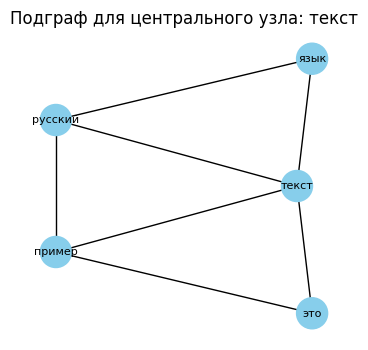

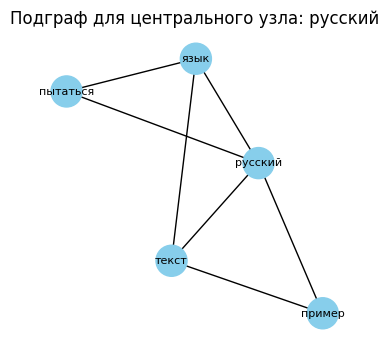

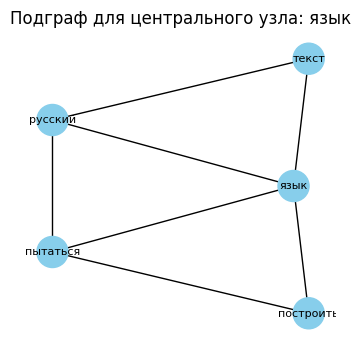

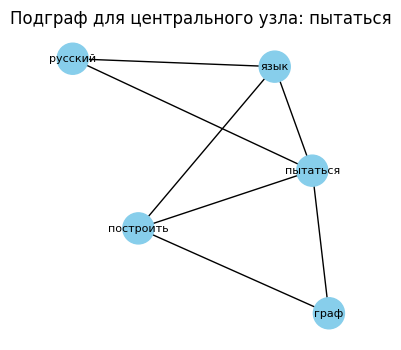

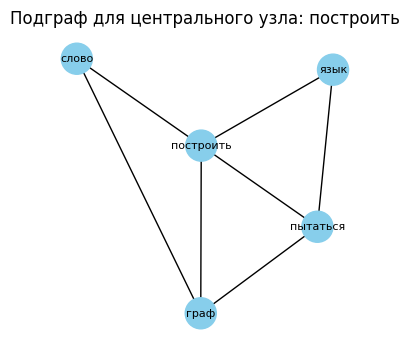

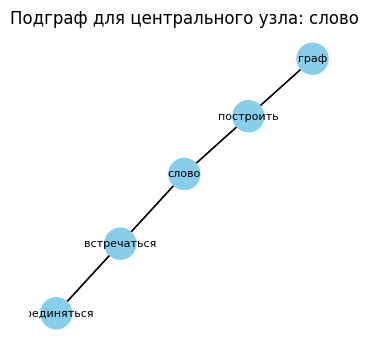

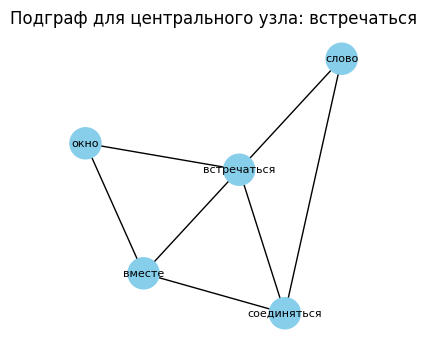

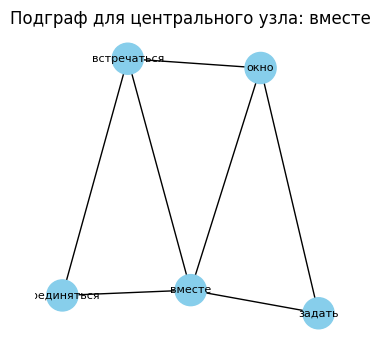

In [33]:
def visualize_subgraph(sub_nodes, A, title="Subgraph"):
    """
    Функция визуализации подграфа с использованием раскладки Kamada-Kawai.
    
    Аргументы:
      sub_nodes: список узлов подграфа (фиксированной длины, может содержать фиктивные узлы "DUMMY").
      A: матрица смежности подграфа (numpy-массив размера (d, d)).
      title: заголовок для рисунка.
    """
    # Создаем новый граф для визуализации
    H = nx.Graph()
    d = len(sub_nodes)
    
    # Добавляем узлы. Фиктивные узлы тоже добавляем, можно отобразить их другим цветом.
    for node in sub_nodes:
        H.add_node(node)
        
    # Добавляем ребра: если между парой узлов в матрице A вес > 0 и оба узла не фиктивные.
    for i in range(d):
        for j in range(i+1, d):
            if sub_nodes[i] != "DUMMY" and sub_nodes[j] != "DUMMY":
                weight = A[i, j]
                if weight > 0:
                    H.add_edge(sub_nodes[i], sub_nodes[j], weight=weight)
    
    # Вычисляем позиции узлов с помощью Kamada-Kawai раскладки
    pos = nx.kamada_kawai_layout(H)
    
    # Определяем цвета для узлов: фиктивные узлы выделим красным, остальные – голубым
    node_colors = ['red' if node == "DUMMY" else 'skyblue' for node in H.nodes()]
    
    # Рисуем граф
    plt.figure(figsize=(4, 4))
    nx.draw_networkx(H, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Пример: визуализируем все подграфы из словаря subgraphs
# Предполагается, что subgraphs получен ранее с помощью функции get_subgraphs(G, top_N, d)
for center, sg in subgraphs.items():
    title = f"Подграф для центрального узла: {center}"
    visualize_subgraph(sg["nodes"], sg["adj"], title=title)

Превратим узлы подграфов в embendings

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

In [1]:
def load_transformer_model(model_name=""):
    """
    :param model_name: название модели на hf
    :return tokenizer, model: токенайзер и модель
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    return tokenizer, model

In [ ]:
def get_transformer_embedding(word, tokenizer, model):
    """
    Функция для получения эмбеддинга для отдельного слова, используя трансформер.
    Если слово токенизируется на несколько субслов, эмбеддинги усредняются.
    :param word: слово
    :param tokenizer: токенайзер
    :param model: модель
    :return embedding: эмбеддинг слова
    """
    encoded_input = tokenizer(word, return_tensors='pt', add_special_tokens=False)
    with torch.no_grad():
        output = model(**encoded_input)
    token_embeddings = output.last_hidden_state  # shape: (1, N, D)
    embedding = token_embeddings.mean(dim=1).squeeze().cpu().numpy()  # shape: (D,)
    return embedding

In [ ]:
def get_embedding_matrix_for_subgraph(subgraph, tokenizer, model, embedding_dim):
    """
    Для подграфа, представленного словарём с ключом "nodes" (список узлов),
    формирует матрицу эмбеддингов размером (d x embedding_dim), где d – число узлов.
    Если узел равен "DUMMY", возвращается вектор нулей.
    
    :param subgraph: сабграф (подграф)
    :param tokenizer: токенайзер
    :param model: модель
    :param embedding_dim: размерность эмбеддингов
    :return: пограф с узлами-эмбеддингами
    """
    nodes = subgraph["nodes"]
    embeddings = []
    for node in nodes:
        if node == "DUMMY":
            embeddings.append(np.zeros(embedding_dim))
        else:
            emb = get_transformer_embedding(node, tokenizer, model)
            # Если размер эмбеддинга не совпадает с embedding_dim, можно усечь или дополнить нулями:
            if emb.shape[0] != embedding_dim:
                if emb.shape[0] > embedding_dim:
                    emb = emb[:embedding_dim]
                else:
                    emb = np.pad(emb, (0, embedding_dim - emb.shape[0]), 'constant')
            embeddings.append(emb)
    return np.vstack(embeddings)

In [ ]:
tokenizer, model = load_transformer_model("ai-forever/ru-en-RoSBERTa")
embedding_dim = model.config.hidden_size

In [ ]:
subgraph_data = {}
for center, sg in subgraphs.items():
    emb_matrix = get_embedding_matrix_for_subgraph(sg, tokenizer, model, embedding_dim)
    subgraph_data[center] = {
        "nodes": sg["nodes"],
        "adj": sg["adj"],
        "embeddings": emb_matrix
    }

for center, data in subgraph_data.items():
    print(f"Центральный узел: {center}")
    print("Узлы подграфа:", data["nodes"])
    print("Размер матрицы эмбеддингов:", data["embeddings"].shape)
    print("Матрица смежности:\n", data["adj"])
    print("-" * 40)

## Graph CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class GraphCNN(nn.Module):
    def __init__(self, num_classes, graph_size=20, neighbor_size=10, num_channels=100):
        """
        Параметры:
          num_classes   - число классов (например, 5)
          graph_size    - число подграфов для документа (например, 20)
          neighbor_size - число узлов в каждом подграфе (например, 10)
          num_channels  - размерность эмбеддингов узлов (например, 100)
        """
        super(GraphCNN, self).__init__()
        self.graph_size = graph_size
        self.neighbor_size = neighbor_size
        self.num_channels = num_channels
        
        # Предполагается, что входной тензор имеет форму:
        # [batch_size, 1, graph_size, neighbor_size * num_channels]
        # Здесь "neighbor_size * num_channels" – это объединённое представление каждого подграфа,
        # где каждая строка соответствует узлу с его эмбеддингом.
        
        # Сверточный слой 1: сворачиваем по оси "узлов подграфа"
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(1, 5), stride=(1, 5), padding=0)
        self.norm1 = nn.LocalResponseNorm(size=5, alpha=0.001/9.0, beta=0.75, k=1.0)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        
        # Сверточный слой 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(1, 5), stride=1, padding=0)
        self.norm2 = nn.LocalResponseNorm(size=5, alpha=0.001/9.0, beta=0.75, k=1.0)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        
        # Сверточный слой 3
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(1, 5), stride=1, padding=0)
        self.norm3 = nn.LocalResponseNorm(size=5, alpha=0.001/9.0, beta=0.75, k=1.0)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        
        # Вычисление размера выхода после сверточных слоев.
        conv_output_size = self._get_conv_output_size()
        
        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, 96)
        self.fc3 = nn.Linear(96, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def _get_conv_output_size(self):
        # Примерное вычисление размеров:
        # Начальный размер по оси "подграфов" равен graph_size (например, 20).
        # По оси "узлов" размер равен neighbor_size * num_channels (например, 10*100 = 1000).
        # При этом сверточные операции осуществляются только по оси "узлов" (ширина).
        size = self.neighbor_size * self.num_channels  # например, 1000
        # Применяем conv1: kernel=5, stride=5
        size = (size - 5) // 5 + 1  
        size = size // 2  # pool1
        size = size - 4   # conv2: kernel=5, stride=1
        size = size // 2  # pool2
        size = size - 4   # conv3
        size = size // 2  # pool3
        # Итоговый размер умножаем на число каналов последнего свёрточного слоя (96)
        return size * 96
    
    def forward(self, x):
        """
        x: входной тензор формы [batch_size, graph_size, neighbor_size * num_channels]
        Мы добавляем измерение канала и получаем форму [batch_size, 1, graph_size, neighbor_size * num_channels]
        """
        x = x.unsqueeze(1)  # добавляем канал: [batch_size, 1, graph_size, neighbor_size * num_channels]
        x = self.pool1(self.norm1(F.relu(self.conv1(x))))
        x = self.pool2(self.norm2(F.relu(self.conv2(x))))
        x = self.pool3(self.norm3(F.relu(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        logits = self.fc3(x)  # Логиты для каждого класса
        return logits


### Рекурсивная регуляризация

In [ ]:
def compute_dependencies_loss(model, hierarchy, dependency_weight=0.00005):
    """
    Реализация рекурсивной регуляризации.
    hierarchy: словарь вида {child_idx: parent_idx} для меток.
    Например:
        {1: 0, 2: 0, 4: 3} означает, что классы 1 и 2 являются дочерними для класса 0, а класс 4 — для класса 3.
    
    Функция минимизирует разницу между весами последнего слоя (self.fc3) для иерархически связанных меток.
    """
    from collections import defaultdict
    inner_nodes = set(hierarchy.values())  # родительские (внутренние) узлы
    nodes_params = defaultdict(list)
    fc3_weights = model.fc3.weight  # размер [num_classes, hidden_dim] (например, [num_classes, 96])
    
    for child, parent in hierarchy.items():
        if parent != -1:  # если не корень
            nodes_params[parent].append(fc3_weights[child])
            # Если дочерний класс также является родительским (т.е. внутренний), можно добавить и его
            if child in inner_nodes:
                nodes_params[child].append(fc3_weights[child])
    
    averaged_params = {}
    for node, params in nodes_params.items():
        averaged_params[node] = torch.mean(torch.stack(params), dim=0)
    
    reg_loss = 0.0
    for child, parent in hierarchy.items():
        child_weights = fc3_weights[child]
        if parent != -1:
            if parent in averaged_params:
                parent_weights = averaged_params[parent]
            else:
                parent_weights = fc3_weights[parent]
            reg_loss += torch.sum((child_weights - parent_weights) ** 2)
    
    return dependency_weight * reg_loss

### Обучение

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TextGraphDataset(Dataset):
    def __init__(self, documents, labels, tokenizer, transformer_model,
                 window_size=4, top_N=20, d=10, embedding_dim=100):
        """
        documents: список документов (строк)
        labels: список меток (целые числа)
        tokenizer, transformer_model: токенайзер и модель трансформера
        window_size, top_N, d, embedding_dim: гиперпараметры
        """
        self.documents = documents
        self.labels = labels
        self.tokenizer = tokenizer
        self.transformer_model = transformer_model
        self.window_size = window_size
        self.top_N = top_N
        self.d = d
        self.embedding_dim = embedding_dim

    def __len__(self):
        return len(self.documents)
    
    def __getitem__(self, idx):
        text = self.documents[idx]
        label = self.labels[idx]
        tokens = preprocess_text(text)
        G = build_graph_of_words(tokens, window_size=self.window_size)
        subgraphs = get_subgraphs(G, top_N=self.top_N, d=self.d)
        embedding_matrices = []
        for sg in subgraphs:
            emb_matrix = get_embedding_matrix_for_subgraph(sg, self.tokenizer, self.transformer_model, self.embedding_dim)
            embedding_matrices.append(emb_matrix)
        # Получаем тензор для документа: форма [top_N, d, embedding_dim]
        X_np = np.stack(embedding_matrices, axis=0)
        # Объединяем последние две оси: получаем форму [top_N, d * embedding_dim]
        X_np = X_np.reshape(self.top_N, self.d * self.embedding_dim)
        X_tensor = torch.tensor(X_np, dtype=torch.float)
        return X_tensor, label

In [ ]:
# Собираем данные в один тензор: 
# x_tensor имеет форму [batch_size, graph_size, neighbor_size * num_channels]
# Здесь batch_size = 1 (один документ), graph_size = число подграфов (например, 20),
# neighbor_size = 10, num_channels = 100.
x_np = np.stack(subgraph_data, axis=0)  # shape: (20, 10, 100)
x_tensor = torch.tensor(x_np, dtype=torch.float).unsqueeze(0)  # [1, 20, 10*100] (сжимаем последнюю размерность)
# Для сверточной модели нам необходимо объединить оси neighbor_size и num_channels
# Из x_np можно получить новую форму: (20, 10*100) и затем добавить batch dimension.

# Этап 3: Создаем и обучаем Graph-CNN
num_classes = 5
model = GraphCNN(num_classes=num_classes, graph_size=20, neighbor_size=10, num_channels=100)

# Пример оптимизатора и цикла обучения (для одного документа)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Пример иерархии меток (словарь: дочерняя метка -> родительская метка)
hierarchy = {1: 0, 2: 0, 4: 3}  # пример
lambda_reg = 0.00005
label = 2 # класс
num_epochs = 50
target = torch.tensor([label], dtype=torch.long)
for epoch in range(1, num_epochs+1):
    model.train()
    optimizer.zero_grad()
    logits = model(x_tensor)
    classification_loss = loss_fn(logits.unsqueeze(0), target)
    reg_loss = compute_dependencies_loss(model, hierarchy, dependency_weight=lambda_reg)
    total_loss = classification_loss + reg_loss
    total_loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4f}, Cls Loss = {classification_loss.item():.4f}, Reg Loss = {reg_loss.item():.4f}")

# После обучения модель можно применять к новым документам (в режиме eval)
model.eval()
with torch.no_grad():
    pred_logits = model(x_tensor)
    pred_class = torch.argmax(pred_logits).item()
    print("Предсказанный класс:", pred_class)